In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as si
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

[*********************100%***********************]  1 of 1 completed
C:\Users\ironp\AppData\Local\Temp\ipykernel_15464\3710125162.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = data['Close'][-1]


Price            Close        High         Low        Open    Volume
Date                                                                
2024-07-05  551.089172  551.496521  547.591688  548.237551  41488400
2024-07-08  551.725098  552.688859  550.642049  551.884047  36110500
2024-07-09  552.261658  553.612936  551.963590  552.698843  27289700
2024-07-10  557.726440  558.074175  553.205582  553.503649  38701200
2024-07-11  552.917358  558.729943  552.271556  557.845626  53054200
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2024-07-05 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   124 non-null    float64
 1   High    124 non-null    float64
 2   Low     124 non-null    float64
 3   Open    124 non-null    float64
 4   Volume  124 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 5.8 KB
None
Current Price (S): 588.219970703125
Call Price: 1.7370878188441878
Put Price: 29

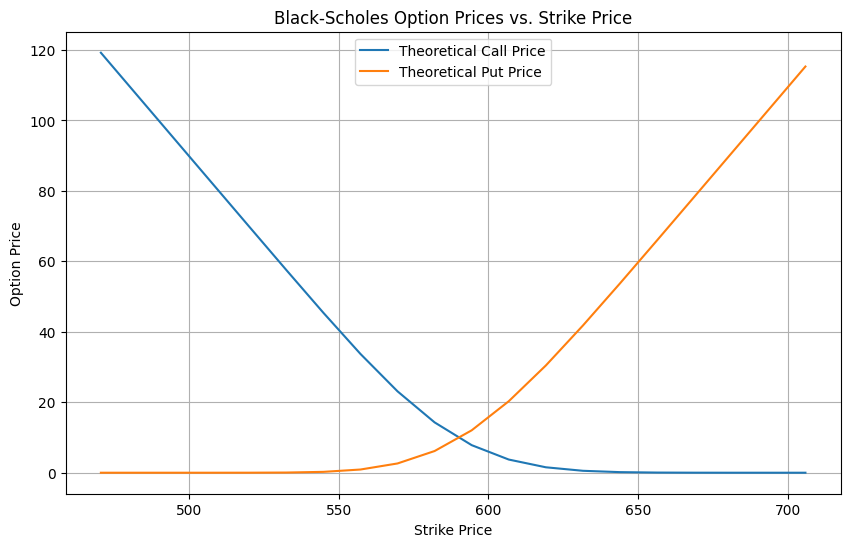

In [2]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """Calculates Black-Scholes option price."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    try:
        if option_type == "call":
            price = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
        elif option_type == "put":
            price = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0)
        else:
            raise ValueError("Invalid option type. Must be 'call' or 'put'.")
        return price
    except Exception as e:
        print(f"Error in black_scholes: {e}")
        return np.nan

def calculate_greeks(S, K, T, r, sigma, option_type="call"):
    """Calculates option Greeks."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    try:
        if option_type == "call":
            delta = si.norm.cdf(d1, 0.0, 1.0)
            gamma = si.norm.pdf(d1, 0.0, 1.0) / (S * sigma * np.sqrt(T))
            vega = S * si.norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
            theta = -(S * si.norm.pdf(d1, 0.0, 1.0) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
            rho = K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
        elif option_type == "put":
            delta = si.norm.cdf(d1, 0.0, 1.0) - 1
            gamma = si.norm.pdf(d1, 0.0, 1.0) / (S * sigma * np.sqrt(T))
            vega = S * si.norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
            theta = -(S * si.norm.pdf(d1, 0.0, 1.0) * sigma) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
            rho = -K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
        else:
            raise ValueError("Invalid option type. Must be 'call' or 'put'.")
        return {"delta": delta, "gamma": gamma, "vega": vega, "theta": theta, "rho": rho}
    except Exception as e:
        print(f"Error in calculate_greeks: {e}")
        return {greek: np.nan for greek in ["delta", "gamma", "vega", "theta", "rho"]}

ticker = "SPY"
end_date = datetime.now()
start_date = end_date - timedelta(days=6 * 30)

try:
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        print(f"Error: No data downloaded for {ticker}.")
        exit()
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

# Simplify column index
data.columns = data.columns.droplevel(level=1)

print(data.head())
print(data.info())

if 'Close' in data.columns:
    S = data['Close'][-1]
    sigma = data['Close'].pct_change().dropna().std() * np.sqrt(252)
elif 'Adj Close' in data.columns:
    S = data['Adj Close'][-1]
    sigma = data['Adj Close'].pct_change().dropna().std() * np.sqrt(252)
else:
    print("Error: Neither 'Close' nor 'Adj Close' found.")
    exit()

K = S * 1.05
T = 1/12
r = 0.04
sigma = data['Close'].pct_change().dropna().std() * np.sqrt(252) if 'Close' in data.columns else data['Adj Close'].pct_change().dropna().std() * np.sqrt(252)

call_price = black_scholes(S, K, T, r, sigma, "call")
put_price = black_scholes(S, K, T, r, sigma, "put")

call_greeks = calculate_greeks(S, K, T, r, sigma, "call")
put_greeks = calculate_greeks(S, K, T, r, sigma, "put")

print(f"Current Price (S): {S}")
print(f"Call Price: {call_price}")
print(f"Put Price: {put_price}")
print("Call Greeks:", call_greeks)
print("Put Greeks:", put_greeks)

strikes = np.linspace(S * 0.8, S * 1.2, 20)
call_prices_plot = [black_scholes(S, k, T, r, sigma, "call") for k in strikes]
put_prices_plot = [black_scholes(S, k, T, r, sigma, "put") for k in strikes]

plt.figure(figsize=(10, 6))
plt.plot(strikes, call_prices_plot, label="Theoretical Call Price")
plt.plot(strikes, put_prices_plot, label="Theoretical Put Price")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Black-Scholes Option Prices vs. Strike Price")
plt.legend()
plt.grid(True)
plt.show()